<a href="https://colab.research.google.com/github/yhc-666/StyleTraceback/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.metrics as metrics
import tensorflow.keras.applications.resnet as resnet

target_shape = (200, 200)


### **1. Load the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
anchor_images_path = "/content/drive/MyDrive/siamese/anchor"
positive_images_path = "/content/drive/MyDrive/siamese/positive"

### **2. Prepare the data**

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = [str(os.path.join(anchor_images_path, f)) for f in os.listdir(anchor_images_path)]


positive_images = [str(os.path.join(positive_images_path, f)) for f in os.listdir(positive_images_path)]

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

#### see how our triplets look like

In [ ]:
print(anchor_images)
print(positive_images)

['/content/drive/MyDrive/siamese/anchor/diana21.jpg', '/content/drive/MyDrive/siamese/anchor/diana47.jpg', '/content/drive/MyDrive/siamese/anchor/jackie11.jpg', '/content/drive/MyDrive/siamese/anchor/diana31.jpg', '/content/drive/MyDrive/siamese/anchor/diana64.jpg', '/content/drive/MyDrive/siamese/anchor/diana9.jpg', '/content/drive/MyDrive/siamese/anchor/43.jpg', '/content/drive/MyDrive/siamese/anchor/jackie39.jpg', '/content/drive/MyDrive/siamese/anchor/42.jpg', '/content/drive/MyDrive/siamese/anchor/jackie7.jpg', '/content/drive/MyDrive/siamese/anchor/diana26.jpg', '/content/drive/MyDrive/siamese/anchor/jackie28.jpg', '/content/drive/MyDrive/siamese/anchor/diana43.jpg', '/content/drive/MyDrive/siamese/anchor/51.jpg', '/content/drive/MyDrive/siamese/anchor/diana13.jpg', '/content/drive/MyDrive/siamese/anchor/40.jpg', '/content/drive/MyDrive/siamese/anchor/50.jpg', '/content/drive/MyDrive/siamese/anchor/25.jpg', '/content/drive/MyDrive/siamese/anchor/diana8.jpg', '/content/drive/MyDri

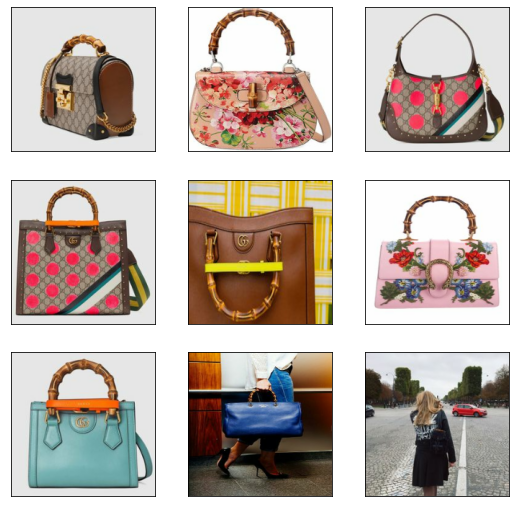

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

### **3. Construct our CNN (encoder)**

We will use model "Embedding" to encode images: input an image, output the encoding(256d vector) for that image.

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = tf.keras.layers.Flatten()(base_cnn.output)
dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
output = tf.keras.layers.Dense(256)(dense2)

embedding = tf.keras.Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94781440/94765736 [==============================] - 0s 0us/step


### **4. Construct the Siamese model which will be trained**

The Model "Embedding" we set will be applied here. And by training this Siamese model we train our encoder.

In [ ]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
anchor_input = tf.keras.layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = tf.keras.layers.Input(name="positive", shape=target_shape + (3,))
negative_input = tf.keras.layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

Use triplet loss

In [ ]:
class SiameseModel(tf.keras.Model):

    def __init__(self, siamese_network, margin=1):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

### **5. Compile and train our model**

In [ ]:
from tensorflow.keras.optimizers import RMSprop

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=RMSprop(lr=0.001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


5/5 [==============================] - 16s 1s/step - loss: 48867.7656 - val_loss: 103.0392
Epoch 2/10
5/5 [==============================] - 3s 704ms/step - loss: 242.6675 - val_loss: 4.1104
Epoch 3/10
5/5 [==============================] - 3s 675ms/step - loss: 13.7351 - val_loss: 3.3796
Epoch 4/10
5/5 [==============================] - 3s 682ms/step - loss: 2.6400 - val_loss: 1.3880
Epoch 5/10
5/5 [==============================] - 3s 678ms/step - loss: 1.2449 - val_loss: 0.8627
Epoch 6/10
5/5 [==============================] - 3s 665ms/step - loss: 1.0587 - val_loss: 0.8700
Epoch 7/10
5/5 [==============================] - 3s 704ms/step - loss: 0.8893 - val_loss: 0.7186
Epoch 8/10
5/5 [==============================] - 3s 670ms/step - loss: 1.0817 - val_loss: 2.9368
Epoch 9/10
5/5 [==============================] - 3s 679ms/step - loss: 2.0210 - val_loss: 2.0819
Epoch 10/10
5/5 [==============================] - 3s 687ms/step - loss: 1.4024 - val_loss: 1.0433


### **6. Check the result**

Positive similarity: 0.99990165
Negative similarity 0.99989885


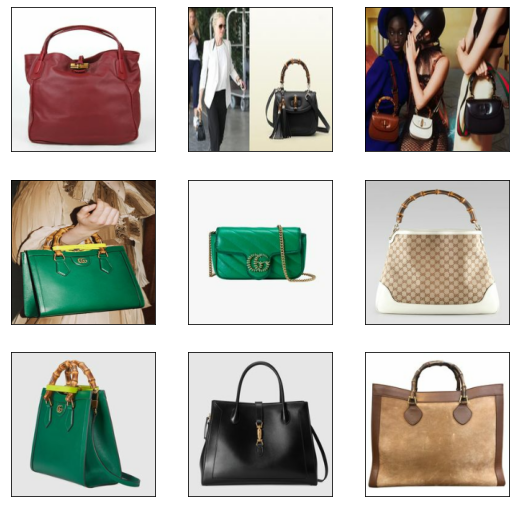

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())